#### Brain and body weights

In [1]:
import pandas as pd

# Load data
data_df = pd.read_csv("c4_brain-body-weights.csv")

# First five rows
data_df.head()


,body,brain,mammal
0,1.6,-2.0,Lesser short-tailed shrew
1,2.3,-1.4,Little brown bat
2,3.1,-1.2,Big brown bat
3,3.1,-0.9,Mouse
4,3.9,-1.1,Musk shrew


The data contains measurements of brain and body weights of 62 animals and three dinosaurs (the outliers).

We saw in the previous course that there is a linear relationship between the logarithm of the brain and body weights. For this reason, the brain and body columns in the DataFrame from above contain the logarithm of the original weights. Let’s plot the data.



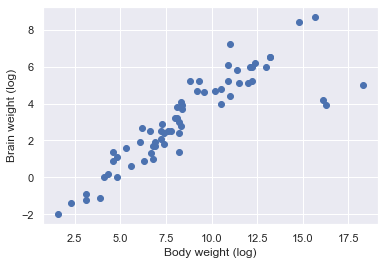

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Activate Seaborn
sns.set()

# Plot data
plt.scatter(data_df.body, data_df.brain)
plt.xlabel("Body weight (log)")
plt.ylabel("Brain weight (log)")
plt.show()

We can see in the plot that there are three clear outliers. For this example, we will keep them in the data and train our network using Huber loss.

Let’s see how to define our linear regression from above with TensorFlow.

#### Variables
First, we need to import the library.

In [3]:
import tensorflow as tf

In [4]:
#We can now create the a and b parameters with the Variable object.

# Initialize slope and intercept parameters
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")
print(a)
print(b)

<tf.Variable 'slope:0' shape=() dtype=float64, numpy=0.0>
<tf.Variable 'intercept:0' shape=() dtype=float64, numpy=0.0>


The tf.Variable() allows us to define a tensor whose value can be changed after running certain operation on it. We need to specify an initial value. In our case, we can initialize the two parameters to zero. TensorFlow assigns a data type to each variable (and to every tensor in general). By default, it’s the data type of the initial value. In our case, 0 is an integer value but both variables should be floating point numbers. Hence, we need to specify the data type by setting dtype=tf.float64.

#### Constants
Now that we have defined the model parameter to be trained, let’s create the input and output variables. Usually, these are constant values. We can create them with the tf.constant() method.



In [5]:
# Import input/target data
x = tf.constant(data_df.body)
y = tf.constant(data_df.brain)

print(x)

tf.Tensor(
[ 1.6  2.3  3.1  3.1  3.9  4.1  4.3  4.6  4.6  4.8  4.8  5.3  5.6  6.1
  6.2  6.3  6.6  6.7  6.8  6.8  6.9  6.9  7.2  7.2  7.3  7.4  7.4  7.6
  7.8  8.   8.1  8.1  8.2  8.2  8.2  8.3  8.3  8.4  8.4  8.8  9.2  9.3
  9.6 10.2 10.5 10.5 10.9 10.9 11.  11.  11.4 11.5 12.  12.1 12.2 12.2
 12.4 13.  13.2 13.2 14.8 15.7 16.1 16.3 18.3], shape=(65,), dtype=float64)


We can now connect the nodes using the * and + operations.



In [6]:
# Compute predictions
y_hat = a * x + b

print(y_hat)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(65,), dtype=float64)


As a side note, the same computation could have also been achieved with using the more explicit notation: tf.add(tf.multiply(a, x), b)

#### Loss function
Let’s define the loss function. TensorFlow provides a set of operations similar to Numpy to work with tensors. For instance, we can define the mean squared error (MSE) using the square() and reduce_mean() functions.

In [7]:
# Mean squared error (MSE)
loss = tf.reduce_mean(  # Equivalent to np.mean()
    tf.square(          # Equivalent to np.square()
        y - y_hat       # Implements broadcasting like Numpy
    )
)

tf.print(loss)  # instead of print(), only print the value

15.904769230769229


Note that TensorFlow implements a few predefined loss functions in its keras.losses module. You can take a look at this page to see the different possibilities. For instance, we will recompute the MSE using the following.

In [8]:
tf.keras.losses.MSE(y, y_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=15.90476923076923>

We will now use the Huber loss one for our network.

In [9]:
# Huber loss
huber_loss = tf.keras.losses.Huber(delta=1.0)
loss = huber_loss(y, y_hat)
loss.numpy()

2.9202309

### Gradients and automatic differentiation

After defining the loss term, we need to compute the gradients with respect to the model parameters in order to perform the training. For that, TensorFlow employs GradientTape API for automatic differentiation. First, we need to state all the relevant operations inside the context of tf.GradientTape() via a with statement. This allows TensorFlow to record these operations on a “tape”. Once this is setup, we can then use the gradient() method to compute all the gradients.

In [10]:
# Automatic differentiation
with tf.GradientTape() as tape:
    y_hat = a * x + b
    loss = huber_loss(y, y_hat) # Uses the 'y_hat' definition from the previous line

grad_a, grad_b = tape.gradient(loss, [a, b])
print(grad_a)
print(grad_b)

tf.Tensor(-7.976000003796071, shape=(), dtype=float64)
tf.Tensor(-0.7953846156597137, shape=(), dtype=float64)


In the code above, the gradients of loss with respect to both variables a and b are computed.

#### Optimizer
To train our model, we need to define an optimizer. You can take a look at this page which lists the different optimizers available in TensorFlow. Let’s use a simple gradient descent strategy.

In [11]:
# Create the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

In this code, we create a Stochastic Gradient Descent (SGD) optimizer and set its learning rate to 0.1. To apply the optimization step, we will use the apply_gradients() method.

In [12]:
# Update the parameters according to gradient descent procedure (learning)
optimizer.apply_gradients(zip([grad_a, grad_b], [a, b]))

print(a)
print(b)

<tf.Variable 'slope:0' shape=() dtype=float64, numpy=0.7976000122647733>
<tf.Variable 'intercept:0' shape=() dtype=float64, numpy=0.07953846275118681>


As you can notice, the optimizer automatically updates the slope and the intercept by applying the following rules when calling the apply_gradients() method:

a = a - learning_rate*grad_a
b = b - learning_rate*grad_b

Note that one can use the minimize() method to do the last two operations, automatic differentiation and optimization, in one shot. The minimize() method computes the gradients then applies the optimization step. It combines tf.GradientTape(), gradient(), and apply_gradients().

In [13]:
# Second alternative (all in one step)

# Reinitialize slope and intercept to zero
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")

# Run the optimizer
optimizer.minimize(loss=lambda: huber_loss(y, a * x + b), var_list=[a, b])
# The `loss` parameter is either a callable with no argument or a Tensor.

print(a)
print(b)


<tf.Variable 'slope:0' shape=() dtype=float64, numpy=0.7976000122647733>
<tf.Variable 'intercept:0' shape=() dtype=float64, numpy=0.07953846275118681>


There is also a third alternative that requires tf.GradientTape() without explicitly computing the gradients using the gradient() method. For that, we need to pass the tape parameter inside the minimize() method.



In [14]:
# Third alternative

# Reinitialize slope and intercept to zero
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")


# Create tf.GradientTape
with tf.GradientTape() as tape:
    y_hat = a * x + b
    loss = huber_loss(y, y_hat)

# Run the optimizer
optimizer.minimize(loss=loss, var_list=[a, b], tape=tape)
# The `loss` parameter is a Tensor here.

print(a)
print(b)

<tf.Variable 'slope:0' shape=() dtype=float64, numpy=0.7976000122647733>
<tf.Variable 'intercept:0' shape=() dtype=float64, numpy=0.07953846275118681>


### Training
Let’s now group everything together and perform the training to learn the a and b parameters.

In [15]:
# Initialize slope and intercept parameters
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")

# Import input/target data
x = tf.constant(data_df.body)
y = tf.constant(data_df.brain)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# Monitor the a/b and loss values
loss_values = []
a_values = []
b_values = []

# Run 100 times the training operation
for _ in range(100):
    with tf.GradientTape() as tape:
        y_hat = a * x + b
        loss = huber_loss(y, y_hat)
    optimizer.minimize(loss=loss, var_list=[a, b], tape=tape)
    # Another alternative
    # grad_a, grad_b = tape.gradient(loss, [a,b])
    # optimizer.apply_gradients(zip([grad_a,grad_b],[a,b]))

    # Save values
    a_values.append(a.numpy())  # convert to numpy (tf.Variable is mutable)
    b_values.append(b.numpy())
    loss_values.append(loss)

In this code, we run the training operation a hundred times using a for loop that iterates over the list of digits between 0 and 99 generated with the range() function. At each iteration, we save the loss and parameter values into the loss_values, a_values and b_values lists. Note that we use the “throwaway” variable _ to discard unused results.

Let’s plot the loss and parameter values.

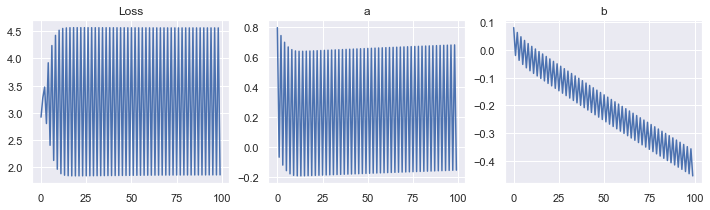

In [16]:
# Create figure with a subplot for each list of values
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# Plot loss values
ax1.set_title("Loss")
ax1.plot(loss_values)

# Plot slope values
ax2.set_title("a")
ax2.plot(a_values)

# Plot intercept values
ax3.set_title("b")
ax3.plot(b_values)

plt.show()

As we can see, the loss value oscillates between 4.5 and 2 which means that gradient descent is having issues learning the a and b values.
We saw in the last course that the algorithm is sensitive to the scale of the input data. Let’s try to standardize the body weights. Instead of modifying our data, let’s add a standardization operation in our network that standardizes the values in x using the mean and standard deviation statistics of the body weights in data_df.



In [17]:
import numpy as np

# Compute mean and std of input variable
print("Mean:", np.mean(data_df.body))
print("Std:", np.std(data_df.body))

Mean: 8.643076923076922
Std: 3.538620732204927


In [18]:
def standard_scaling(x):
    return (x - 8.643) / 3.539

We can now repeat the whole training by applying standard_scaling().

In [19]:
# Import input/target data
x = tf.constant(data_df.body)
y = tf.constant(data_df.brain)

# Initialize slope and intercept parameters
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# Monitor the a/b and loss values
loss_values = []
a_values = []
b_values = []

# Run 100 times the training operation
for _ in range(100):
    with tf.GradientTape() as tape:
        x_standardized = standard_scaling(x)
        y_hat = a * x_standardized + b
        loss = huber_loss(y, y_hat)
    optimizer.minimize(loss=loss, var_list=[a, b], tape=tape)

    # Save values
    a_values.append(a.numpy())  # convert to numpy (tf.Variable is mutable)
    b_values.append(b.numpy())
    loss_values.append(loss)

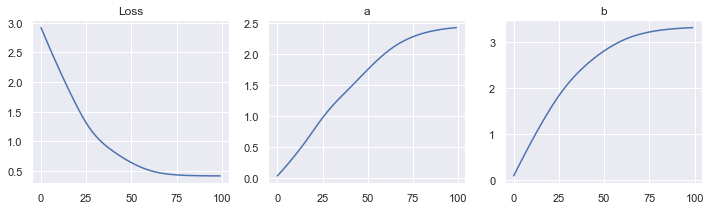

In [25]:
# Create figure with a subplot for each list of values
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# Plot loss values
ax1.set_title("Loss")
ax1.plot(loss_values)

# Plot slope values
ax2.set_title("a")
ax2.plot(a_values)

# Plot intercept values
ax3.set_title("b")
ax3.plot(b_values)

plt.show()

Let’s plot the loss and parameter values (using the same code above).

This time, the loss value keeps decreasing after each iteration and the a and b values seem to stabilize after a hundred iterations.

### Prediction
Finally, let’s see how to use our network to predict brain weights. We will compute the predictions for a hundred sample body weights between the minimum and the maximum body weight values.



In [20]:
# Create a hundred sample body weights
x_values = np.linspace(
    data_df.body.min(),  # Between the minimum
    data_df.body.max(),  # and maximum body weight values
    num=100,
)

In [21]:
# Extract the optimal parameters a and b
a_op = (a_values[-1],)  # last slope value
b_op = b_values[-1]     # last intercept value
y_values = a_op * standard_scaling(x_values) + b_op

We pass the last slope and intercept values from the a_values and b_values lists and save the predictions in a y_values.

Let’s plot the predictions with Seaborn. We plot the data points from the data_df DataFrame and the predictions from the x_values and y_values variables.

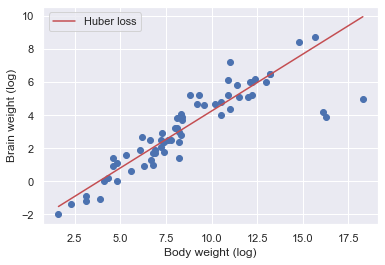

In [22]:
# Plot data with sample predictions
plt.scatter(data_df.body, data_df.brain, label=None)
plt.plot(x_values, y_values, label="Huber loss", color="C3")
plt.xlabel("Body weight (log)")
plt.ylabel("Brain weight (log)")
plt.legend()
plt.show()

Thanks to Huber loss, our linear regression ignores the three outliers and the line fits well the data points.

### Graph execution in TensorFlow
So far, we have built and trained a simple network (a linear regression model) using TensorFlow’s default mode of execution. This mode is called the “eager execution” mode. Eager execution means that TensorFlow operations are immediately, or eagerly, executed in Python through an intuitive interface. This makes debugging and development straightforward. For more on the eager execution mode, check this official documentation page.

However, TensorFlow has another mode of execution that applies distributed training in order to speedup the performance for large models. This mode is called the “graph execution” mode. It enables faster training and takes advantage of distributed setups when available (e.g. GPU). The graph mode creates a new Python data structure out of your code. The new data structure is called dataflow graph, also know as computation graph. This helps to create faster and portable models that work in general coding environments. For more details on the graph mode, you can check the official documentations here and here.

In order to enable the graph mode, one just needs to refactor the code into small functions and use the python decorator @tf.function before each function as shown in the code below.



In [23]:
# Define the loss (if not done yet)
huber_loss = tf.keras.losses.Huber(delta=1.0)

# Define the optimizer (if not done yet)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

In [24]:
# Compute the predictions
@tf.function
def compute_prediction(x, a, b):
    x_standardized = standard_scaling(x)
    y_hat = a * x_standardized + b
    return y_hat


# Compute the loss
@tf.function
def compute_loss(y, y_hat):
    return huber_loss(y, y_hat)


# Train the model
@tf.function
def train(x, y, a, b):
    with tf.GradientTape() as tape:
        y_hat = compute_prediction(x, a, b)
        loss = compute_loss(y, y_hat)
    optimizer.minimize(loss=loss, var_list=[a, b], tape=tape)
    return a, b, loss

From the first sight, these functions look like any other Python function. However, there is something more complicated going in the background when using @tf.function. Underneath, tf.function uses a library called AutoGraph (tf.autograph) to convert our Python code into a more efficient graph-based code.

The tf.fucntion decorator allows TensorFlow to automatically transform the underlying function into a more efficient dataflow graph. It is not required to decorate each of these functions with tf.function. This is because tf.function is applied to the decorated function and all other functions it calls. Here, it is enough to decorate the function train() to guarantee that the graph mode is enabled.

Refactoring the code into small functions is indeed possible in the eager execution mode to better organize the code. This is not what activates the graph mode. It is rather the tf.fucntion decorator that activates the graph mode.

In [26]:
#Let’s now train the model.

# Import input/target data
x = tf.constant(data_df.body)
y = tf.constant(data_df.brain)


# Reinitialize slope and intercept parameters to zero
a = tf.Variable(initial_value=0, dtype=tf.float64, name="slope")
b = tf.Variable(initial_value=0, dtype=tf.float64, name="intercept")


# Monitor the a/b and loss values
loss_values = []
a_values = []
b_values = []

# Run 100 times the training operation
for _ in range(100):
    a_val, b_val, loss_val = train(x, y, a, b)

    # Save values
    a_values.append(a_val.numpy())  # convert to numpy (tf.Variable is mutable)
    b_values.append(b_val.numpy())
    loss_values.append(loss_val)

You can use the time module to compare the performance speed of the eager execution vs. the graph execution modes. For this example, the graph execution is almost twice as fast as the eager execution, but the overall time difference is not that significant because we are training a simple model. In the subsequent units, you will notice the difference when considering a more complex architecture.

Note that in the current TensorFlow graph mode that employs tf.function, the variables tf.Variable are only created once (when the tf.function-decorated functions are first called). Hence, It is recommended to create all the tf.Variable outside such functions. The same applies to tf.keras.optimizers. Furthermore, reinitializing tf.keras.optimizers after the function call might require rerunning the function definition. This issue will not occur if tf.function is not employed (i.e. in the eager mode). It is one of the subtle differences between the eager execution mode and the graph mode. More details in this page.

Let’s now plot the loss and the predictions (using the same code above), to verify that the result is the same.

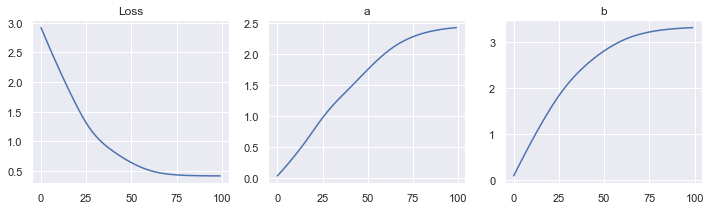

In [27]:
# Create figure with a subplot for each list of values
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# Plot loss values
ax1.set_title("Loss")
ax1.plot(loss_values)

# Plot slope values
ax2.set_title("a")
ax2.plot(a_values)

# Plot intercept values
ax3.set_title("b")
ax3.plot(b_values)

plt.show()

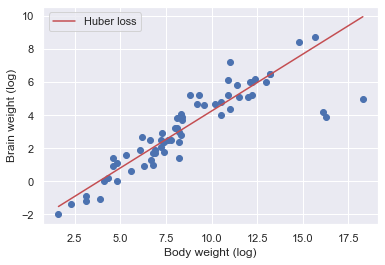

In [28]:
# Plot data with sample predictions
plt.scatter(data_df.body, data_df.brain, label=None)
plt.plot(x_values, y_values, label="Huber loss", color="C3")
plt.xlabel("Body weight (log)")
plt.ylabel("Brain weight (log)")
plt.legend()
plt.show()